Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [x] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [x] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


You won't be able to just copy from the lesson notebook to this assignment.

- Because the lesson was ***regression***, but the assignment is ***classification.***
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [34]:
from sklearn.model_selection import train_test_split

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)
train.shape, val.shape

((47520, 41), (11880, 41))

In [0]:
import numpy as np

def calculate_distance(lat1, lon1, lat2, lon2):
    # Formula to calculate distance in KM between two points using lattitude 
    # and longitude.

    R = 6373 # Radius of earth in km
    lat1 = np.deg2rad(lat1)
    lat2 = np.deg2rad(lat2)
    lon1 = np.deg2rad(lon1)
    lon2 = np.deg2rad(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

cities_dict = {
    'Dar es Salaam' : [-6.8, 39.283333],
    'Mwanza' : [-2.516667, 32.9],
    'Arusha' : [-3.366667, 36.683333],
    'Mbeya' : [-8.9, 33.45],
    'Morogoro' : [-6.824167, 37.663333],
    'Tanga' : [-5.066667, 39.1],
    'Kahama' : [-3.8375, 32.6],
    'Tabora' : [-5.016667, 32.8],
    'Zanzibar City' : [-6.165, 39.199],
    'Kigoma' : [-4.883333, 29.633333],
    'Dodoma' : [-6.173056, 35.741944],
    'Sumbawanga' : [-7.966667, 31.616667],
    'Kasulu' : [4.58, 30.1],
    'Songea' : [-10.683333, 35.65],
    'Moshi' : [-3.334883, 37.340381],
    'Musoma' : [-1.5, 33.8],
    'Shinyanga' : [-3.661944, 33.423056],
    'Iringa' : [-7.766667, 35.7],
    'Singida' : [-4.816667, 34.75],
    'Njombe' : [-9.333333, 34.766667],
    }

def closest_city(data):

    lat = data[0]
    lon = data[1]
    try:
        if np.isnan(lat) or np.isnan(lon):
            return np.nan, np.nan
    except:
        return np.nan, np.nan

    min_distance = 99999
    closest_city = ''
    for key in cities_dict.keys():
        distance = calculate_distance(lat, lon, 
                                      cities_dict[key][0], cities_dict[key][1])
        if distance < min_distance:
            min_distance = distance
            closest_city = key

    return closest_city, min_distance

def get_closest_city_name(data):
    name, _ = closest_city(data)
    return name

def get_closest_city_distance(data):
    _, distance = closest_city(data)
    return distance

def years(data):
    if pd.isna(data[1]):
        return np.nan
    else:
        return (data[0] - data[1].dt.year)

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # quantity & quantity_group are duplicates, so drop one
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)

    # convert date_recorded to datetime format
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')

    # reduce cardinality:
    high_cardinality_features = ['installer', 'funder', 'region', 
                                 'management']
    for n in high_cardinality_features:
        top10 = X[n].value_counts()[:15].index
        X.loc[~X[n].isin(top10), n] = 'OTHER' 

    # create two new features:
    X['closest_city'] = X[['latitude', 'longitude']].apply(get_closest_city_name, axis=1)
    X['closest_city_distance'] = X[['latitude', 'longitude']].apply(get_closest_city_distance, axis=1)
    X['years'] = X['year_recorded'] - X['construction_year']

    # drop some stuff
    X = X.drop(columns='year_recorded')
    X = X.drop(columns='month_recorded')
    X = X.drop(columns='day_recorded')

    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [36]:
train.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,closest_city,closest_city_distance,years
43360,72938,0.0,OTHER,0,OTHER,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,NaN,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,Mbeya,32.222060,NaN
7263,65358,500.0,OTHER,2049,OTHER,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008.0,gravity,gravity,gravity,wua,user-group,pay monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,Njombe,11.413647,3.0
2486,469,25.0,OTHER,290,OTHER,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,VWC,NaN,False,2010.0,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,salty,salty,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,Morogoro,95.793599,1.0
313,1298,0.0,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,0,True,GeoData Consultants Ltd,NaN,NaN,True,NaN,other,other,other,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional,Mwanza,278.480769,NaN
52726,27001,0.0,OTHER,0,OTHER,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,0,True,GeoData Consultants Ltd,VWC,Zeje,True,NaN,mono,mono,motorpump,vwc,user-group,pay per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional,Dodoma,46.440557,NaN


In [37]:
# The status_group column is the target
target = 'status_group'

# Stuff I don't think is gonna be useful:
not_useful = ['num_private', 'construction_year', 'gps_height', 'amount_tsh',
              'scheme_name', 'recorded_by']

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'] + not_useful)

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 100].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

print(len(features))

29


In [47]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(random_state=0)
    )

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': [50, 100, 250, 500], 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    # 'randomforestclassifier__min_features': [1, 2, 3, 4],
    'randomforestclassifier__max_features': uniform(0, 1)
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-2
)

search.fit(X_train, y_train)

pipeline = search.best_estimator_
print(pipeline.score(X_val, y_val))

# Wake me up when it's done... zzz...
from google.colab import output
output.eval_js('new Audio("https://vignette.wikia.nocookie.net/finalfantasy/images/d/db/FFXV_Victory_Fanfare.ogg").play()')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.7317016558445294, randomforestclassifier__n_estimators=50, simpleimputer__strategy=mean 


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.7317016558445294, randomforestclassifier__n_estimators=50, simpleimputer__strategy=mean, score=(train=0.954, test=0.800), total=  13.9s
[CV] randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.7317016558445294, randomforestclassifier__n_estimators=50, simpleimputer__strategy=mean 


[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.7317016558445294, randomforestclassifier__n_estimators=50, simpleimputer__strategy=mean, score=(train=0.969, test=0.797), total=  13.3s
[CV] randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.7317016558445294, randomforestclassifier__n_estimators=50, simpleimputer__strategy=mean 


[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:   28.7s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.7317016558445294, randomforestclassifier__n_estimators=50, simpleimputer__strategy=mean, score=(train=0.972, test=0.802), total=  13.3s
[CV] randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.7317016558445294, randomforestclassifier__n_estimators=50, simpleimputer__strategy=mean 


[Parallel(n_jobs=-2)]: Done   3 out of   3 | elapsed:   42.7s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.7317016558445294, randomforestclassifier__n_estimators=50, simpleimputer__strategy=mean, score=(train=0.969, test=0.802), total=  13.4s
[CV] randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.7317016558445294, randomforestclassifier__n_estimators=50, simpleimputer__strategy=mean 


[Parallel(n_jobs=-2)]: Done   4 out of   4 | elapsed:   56.8s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=20, randomforestclassifier__max_features=0.7317016558445294, randomforestclassifier__n_estimators=50, simpleimputer__strategy=mean, score=(train=0.971, test=0.801), total=  13.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.06743956818279873, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median 


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.06743956818279873, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median, score=(train=0.997, test=0.799), total=  22.5s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.06743956818279873, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median 


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:  1.7min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.06743956818279873, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median, score=(train=0.997, test=0.792), total=  21.8s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.06743956818279873, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median 


[Parallel(n_jobs=-2)]: Done   7 out of   7 | elapsed:  2.1min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.06743956818279873, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median, score=(train=0.997, test=0.799), total=  22.1s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.06743956818279873, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median 


[Parallel(n_jobs=-2)]: Done   8 out of   8 | elapsed:  2.6min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.06743956818279873, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median, score=(train=0.997, test=0.793), total=  21.6s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.06743956818279873, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median 


[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:  3.1min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.06743956818279873, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median, score=(train=0.997, test=0.795), total=  21.7s
[CV] randomforestclassifier__max_depth=15, randomforestclassifier__max_features=0.7115622930757128, randomforestclassifier__n_estimators=50, simpleimputer__strategy=median 
[CV]  randomforestclassifier__max_depth=15, randomforestclassifier__max_features=0.7115622930757128, randomforestclassifier__n_estimators=50, simpleimputer__strategy=median, score=(train=0.874, test=0.798), total=  11.8s
[CV] randomforestclassifier__max_depth=15, randomforestclassifier__max_features=0.7115622930757128, randomforestclassifier__n_estimators=50, simpleimputer__strategy=median 
[CV]  randomforestclassifier__max_depth=15, randomforestclassifier__max_features=0.7115622930757128, randomforestclassifier__n_estimators=50, simpleimputer__strategy=median, score=(train=0.903, test=0.797), t

[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed: 32.6min finished


0.8114478114478114


In [49]:
pipeline = search.best_estimator_
print(pipeline.score(X_val, y_val))

0.8114478114478114


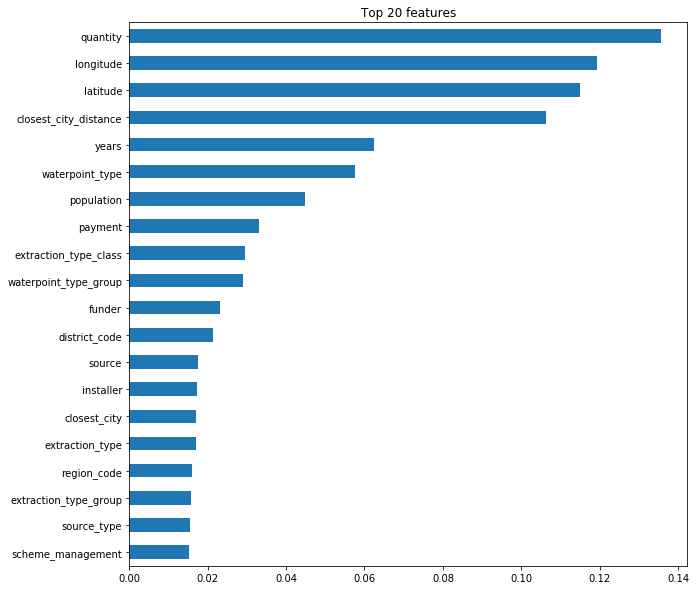

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(train[features])

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [0]:
# Save test results as a .csv:
test['status_group'] = pipeline.predict(test[features])
test[['id', 'status_group']].to_csv('submission.csv', index=False)